### Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import read_pickle,preprocess
from methods import method1_1,method1_2,method2_1,method2_2

# Paths conversion

This first notebook convert the paths to scores path using the scores from the Roberta model. As there are several different subquestions, the final dataframe can be different depending on the analysis that are performed. There is therefore different methods to convert the dataframe, which can be chosen in this notebook.

## Scores analysis

The first step is to load the initial scores from the pickle file

In [2]:
headers=['Article','Negative','Neutral','Positive']
df1=read_pickle(headers)

positive_words=set(open('./Positive words 4.txt').read().splitlines())
negative_words=set(open('./Negative words 4.txt').read().splitlines())

df1.head()

,Article,Negative,Neutral,Positive
0,Matter,0.235663,0.668916,0.095422
1,Common_Tern,0.152064,0.750734,0.097202
2,Restoration_literature,0.169710,0.697821,0.132469
3,European_Kingfisher,0.076588,0.791261,0.132150
4,Abuja,0.119582,0.672143,0.208275


As Roberta output are positive, neutral and negative score, they need to be converted into a single score between [-1,1]. The adjusted score can be calculated with different methods, as shown in the function below. A new dataframe with the article and the calculated score is created for each methods. All the methods and imported from and described in the methods.py script.

In [3]:
def adjust_scores(df,method=1):
    '''
    Calculate the final score from the roberta output
    :param df: dataframe with the positive, neutral and negative scores
    :param method: number of the method used
    '''
    for i in range(len(df)):

        path=f'./plaintext_articles/{df.loc[i,"Article"]}.txt'
        
        with open(path,'r') as file:
            text=file.read()
        
        text=preprocess(text)
        
        pos=df.loc[i,'Positive']
        neg=df.loc[i,'Negative']
        

        if method==1:
            final_score=method1_1(text,pos-neg,positive_words,negative_words,0.5)
        
        if method==2:
            final_score=method1_2(pos,neg)

        df.loc[i,'Score']=final_score

    return df

In [4]:
df_scores1=adjust_scores(df1)[['Article','Score']].copy(deep=True)
df_scores2=adjust_scores(df1,2)[['Article','Score']].copy(deep=True)

pd.concat([df_scores1.head(),df_scores2.head()],axis=1)

,Article,Score,Article,Score
0,Matter,-0.140241,Matter,-0.595093
1,Common_Tern,-0.054862,Common_Tern,-0.360784
2,Restoration_literature,-0.037241,Restoration_literature,-0.219439
3,European_Kingfisher,0.055562,European_Kingfisher,0.420446
4,Abuja,0.088693,Abuja,0.425846


To get a visual of the scores mapping, a histogram is plotted.

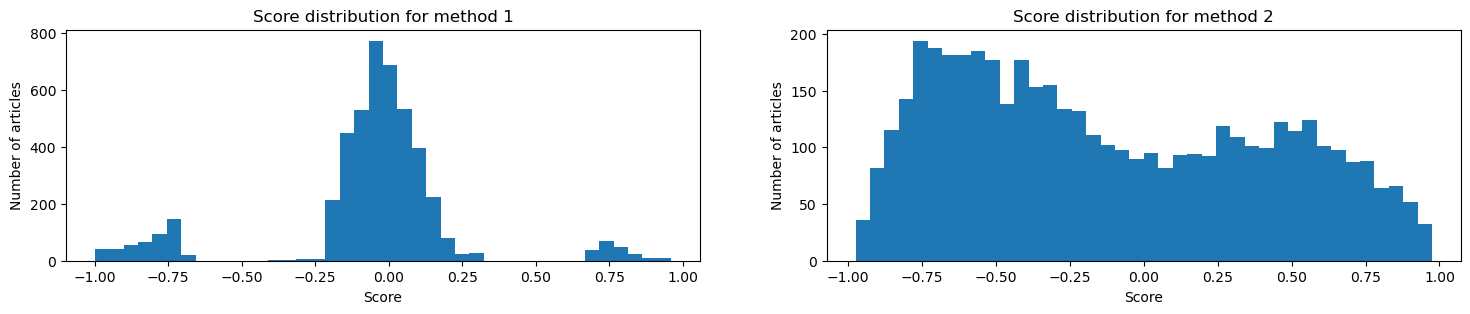

In [5]:
arr_score=[df_scores1['Score'].values,df_scores2['Score'].values]

fig,ax=plt.subplots(1,2,figsize=(18,3))

for i in range(len(arr_score)):
    ax[i].hist(arr_score[i],40)
    ax[i].set_xlabel('Score')
    ax[i].set_ylabel('Number of articles')
    ax[i].set_title(f'Score distribution for method {i+1}')

In [6]:
pos_count=len(df_scores1[df_scores1['Score']>=0.5])
neg_count=len(df_scores1[df_scores1['Score']<=-0.5])
neutral_count=len(df_scores1[(df_scores1['Score']>-0.5) & (df_scores1['Score']<0.5)])

print(f'{pos_count} positive articles ({round(100*pos_count/len(df_scores1))} %) \n{neg_count} negative articles ({round(100*neg_count/len(df_scores1))} %) \n{neutral_count} neutral articles ({round(100*neutral_count/len(df_scores1))} %)')

196 positive articles (4 %) 
461 negative articles (10 %) 
3947 neutral articles (86 %)


The first method not really selective (86% of the articles are considered neutral), but is highly separative (all articles can clearly be labelled as either positive, neutral or negative).
The second method is less separative and more equally distributive.
For now, the first method will be used, but maybe the second and some other methods could be analyzed with validation data in order check the accuracy of the method.

As the first method is highly separative, the labels (Positive, Neutral or Negative) and their corresponding scores (1,0,-1) are added in the dataframe.

In [7]:
conditions = [(df_scores1['Score'] > 0.5),(df_scores1['Score'] >= -0.5) & (df_scores1['Score'] <= 0.5),(df_scores1['Score'] < -0.5)]
choices1 = ['Positive', 'Neutral', 'Negative']
choices2 = [1,0,-1]
df_scores1['Label'] = np.select(conditions, choices1, default='Undefined')
df_scores1['Rounded'] = np.select(conditions, choices2, default='Undefined')

df_scores1['Rounded']=df_scores1['Rounded'].astype(int)

df_scores1[:10]

,Article,Score,Label,Rounded
0,Matter,-0.140241,Neutral,0
1,Common_Tern,-0.054862,Neutral,0
2,Restoration_literature,-0.037241,Neutral,0
3,European_Kingfisher,0.055562,Neutral,0
4,Abuja,0.088693,Neutral,0
5,Dublin,0.141195,Neutral,0
6,Bassoon,0.108070,Neutral,0
7,Indian_Institutes_of_Technology,0.079594,Neutral,0
8,Baroque,0.106084,Neutral,0
9,Myanmar,0.299302,Neutral,0


## Path analysis

The finished and unfinished paths are loaded, assembled and rearranged for the task of interest.

In [8]:
df_f_paths=pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv',sep='\t',skiprows=16,names=['hashedIpAddress','timestamp','durationInSec','Path','rating'])
df_uf_paths=pd.read_csv('./wikispeedia_paths-and-graph/paths_unfinished.tsv',sep='\t',skiprows=16,names=['hashedIpAddress','timestamp','durationInSec','Path','Target','type'])

df_f_paths=df_f_paths[['Path']].copy(deep=True)
df_uf_paths=df_uf_paths[['Path','Target']].copy(deep=True)

df_paths=pd.concat([df_f_paths,df_uf_paths],axis=0,ignore_index=True,sort=False)

df_paths=pd.DataFrame(df_paths)
print(f'There is {len(df_paths)} paths')
df_paths.head()

There is 76193 paths


,Path,Target
0,14th_century;15th_century;16th_century;Pacific...,NaN
1,14th_century;Europe;Africa;Atlantic_slave_trad...,NaN
2,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,NaN


The paths are in string and article form. We create a function that transforms these in score and label paths.

- First method: Remove the articles that the players come back from, as to get only the direct path from the starting article to the target.

- Second method: Keep all the articles, have the whole path with the comebacks

In both methods, the articles next to each other are (hopefully) semantically linked, as the comebacks are just the reverse of the choices a player did. Therefore, both methods are valid, but can be used for different analysis.

In the oscillating path analysis for example, we would like to get rid of the comebacks, as they could incurr false results. (we want to observe oscillation between different articles, not between two articles going back and forth).

In [9]:
def transform_path(path,df=df_scores1,method=1):
    '''
    Add the corresponding scores and rounded scores paths
    :param path: the initial string of articles (separated by ;)
    :param df: the score dataframe used to convert
    :param method: number of the method used
    '''
    
    if method==1:
        list1=method2_1(path)

    elif method==2:
        list1=method2_2(path)

    scores=[]
    labels=[]
    pass
    for article in list1:
        scores.append(df.loc[df['Article']==article,'Score'].values[0])
        labels.append(df.loc[df['Article']==article,'Rounded'].values[0])

    return scores,labels


def transform_df(initial_df,df_score=df_scores1,method=1):
    '''
    Perform the paths transformation on the dataframe
    :param initial_df: dataframe to convert
    :param df_score: the score dataframe used to convert
    :param method: number of the method used
    '''
    df=initial_df.copy(deep=True)
    a=len(df)

    for i in range(a):
        if i%(a//5)==0:
            print(f'{20*(i/(a//5))} %')
        scores,labels=transform_path(df.loc[i,'Path'],df_score,method)
        df.at[i,'Scores']=scores
        df.at[i,'Rounded']=labels

    return df

And the function is now applied on all the paths.

In [10]:
df_paths['Scores']=None
df_paths['Scores'].astype('object')
df_paths['Rounded']=None
df_paths['Rounded'].astype('object')

df_paths1=transform_df(df_paths,method=1)
df_paths2=transform_df(df_paths,method=2)

0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
100.0 %
0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
100.0 %


In [11]:
print(f'There is {len(df_paths1)} paths for method 1 and {len(df_paths2)} paths for method 2')
df_paths1.head()

There is 76193 paths for method 1 and 76193 paths for method 2


,Path,Target,Scores,Rounded
0,14th_century;15th_century;16th_century;Pacific...,NaN,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]"
1,14th_century;Europe;Africa;Atlantic_slave_trad...,NaN,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]"
2,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]"
3,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]"
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,NaN,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]"


The target is also converted to a score, and now that all the useful information are contained as scores in the dataframe, the initial strings are removed.
During this process, we noticed that some target articles were not in the wikispeedia plaintext folder (or spelled wrong) that was analyzed to get the scores corresponding to the articles. The corresponding paths are dropped out of the analysis.


In [12]:
df_paths_list=[df_paths1,df_paths2]
missing_articles=set()

for df in df_paths_list:

    for i in range(len(df)):
        
        target=df.loc[i,'Target']

        if target==target:
            try:
                df.loc[i,'Target score']=df_scores1.loc[df_scores1['Article']==target,'Score'].values[0]
            except:
                missing_articles.add(target)
                df.drop(index=i,inplace=True)

    df.drop(['Path','Target'],axis=1,inplace=True)
    df.reset_index(inplace=True,drop=True)


print(f'The following articles are missing: \n {missing_articles}')
df_paths1.head()

The following articles are missing: 
 {'Kashmir', 'Georgia', 'Usa', 'Christmas', 'C++', 'Podcast', 'Long_peper', 'Western_Australia', 'Bogota', 'English', 'Sportacus', 'Great', 'The', 'The_Rock', 'Macedonia', 'Rat', 'Rss', 'Black_ops_2', 'Test', '_Zebra', 'Netbook', 'Mustard', 'Adolph_Hitler', 'Fats', 'Charlottes_web'}


,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


Finally, the dataframe is stored in a pickle file.

In [13]:
with open('df_paths_direct.pickle', 'wb') as file:
    pickle.dump(df_paths1, file)

with open('df_paths_undirect.pickle', 'wb') as file:
    pickle.dump(df_paths2, file)